In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# this is here to accomodate the old version of calculating the avg psd
# but the new version opens up a fits file that already has all the data
class psd_avg:
    def __init__(self, fitsfilename):
        fd = fits.open(fitsfilename)
        psd_data = fd[1].data
        self.k_radial = psd_data.kval / u.m
        self.psd_radial_cal = psd_data.avg * u.m**2 * u.nm**2 # special for oap
        
        hdr = fd[0].header
        self.k_min = hdr['kmin']/u.m
        self.k_max = hdr['kmax']/u.m
        self.npix_diam = hdr['diam_pix']
        self.delta_k = hdr['delta_k']/u.m
        side = hdr['oversamp']
        self.psd_cal = np.zeros((side, side)) # filler for the pre-existing code
        
        rms_data = fd[2].data
        self.rms_tot = rms_data.rms_tot[-1]*u.nm

In [3]:
# load the data
avg_psd = psd_avg(fitsfilename='radial/psd_oap.fits')

# set initial conditions
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.050*u.m, # not really useful but okay
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 100/u.m,
             'khigh_ll': 1000/u.m,
             'label': 'oap'}

In [10]:
avg_psd.rms_tot

<Quantity 6.9599466 nm>

In [4]:
%%time
# this section does all the fitting
ist = [0, 52, 400]
iend = ist[1:]
iend.append(len(avg_psd.k_radial)-15)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm,0.000005*u.nm, avg_sr_rms]

psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=avg_psd.delta_k*0.2, 
                         k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

/home/jhen/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 26.4 s, sys: 832 ms, total: 27.2 s
Wall time: 16.8 s


In [9]:
ms_refit.psd_rms_sum

<Quantity 7.67768749 nm>

In [7]:
def psd_plot(mdl_set, model_sum, avg_psd, opt_parms, psd_lim):
    k_radial = avg_psd.k_radial.value
    psd_radial = avg_psd.psd_radial_cal.value
    k_range_mdl = mdl_set[0].k_range.value

    color_list=['r', 'b', 'y', 'g', 'c']
    anno_opts = dict(xy=(0.11, .9), xycoords='axes fraction',
                     va='center', ha='center')

    matplotlib.rcParams["font.size"]=20
    plt.figure(figsize=[16,9],dpi=100, facecolor='white')
    gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])

    # top PSD: the modeled portion
    ax0 = plt.subplot(gs[0])  

    # measured data
    ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, 
               label='PSD (measured)')

    # regional pieces
    for j in range(0, len(mdl_set)):
        psd_value = psd.model_full(k=mdl_set[0].k_range, psd_parm=model_sum.psd_parm[j]) * model_sum.psd_weight[j]
        plt_label = '{0}: {1}={2:.2f}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num), 
                                              r'$a_{0}$'.format(j), 
                                              model_sum.psd_weight[j])
        plt_label = plt_label+ '{1}={2:.3f} {3}={4:.3e}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num),
                                                             r'$\alpha$', model_sum.psd_parm[j][0], 
                                                             r'$\beta$', model_sum.psd_parm[j][1].value)
        plt_label = plt_label + '{0}={1:.1e}, {2}={3:.2e}\n'.format(r'$L_{0}$',model_sum.psd_parm[j][2], 
                                                                                   r'$l_{0}$', model_sum.psd_parm[j][3])
        plt_label = plt_label + '{0}={1:.1e}'.format(r'$\sigma_{sr}$', mdl_set[j].rms_sr)
        #plt_label = plt_label + '{0}={1:.2f}'.format(r'$a_{0}$'.format(j), model_sum.psd_weight[j])
        ax0.loglog(mdl_set[j].k_range.value, psd_value.value, color_list[j]+':', linewidth=2,
                   label=plt_label)
        # draw in the color box
        ax0.axvspan(k_radial[mdl_set[j].i_start], k_radial[mdl_set[j].i_end], facecolor=color_list[j], alpha=0.1)

    #mdl_sum_text = 'model sum {0}\nRMS={1:.5f}'.format(r'$\Sigma a_{n}r_{n}$', model_sum.psd_rms_sum)
    mdl_sum_text = 'PSD (model)'
    ax0.loglog(k_range_mdl, model_sum.psd_radial_sum.value, linewidth=3, label=mdl_sum_text)


    ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax0.set_ylim(top=psd_lim[0], bottom=psd_lim[1])
    ax0.set_ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
    ax0.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size':14})

    err_rms = np.sqrt(np.mean(np.square(model_sum.error)))
    ax1 = plt.subplot(gs[1])
    ax1.semilogx(k_radial, model_sum.error, linewidth=2)
    ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k')
    ax1.set_ylim(top=0.4, bottom=-0.4)
    ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax1.set_ylabel('Error ratio')# [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
    ax1.set_xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
    ax1.annotate('Error RMS: {0:.4}'.format(err_rms), **anno_opts, fontsize=15)

    plt.tight_layout()

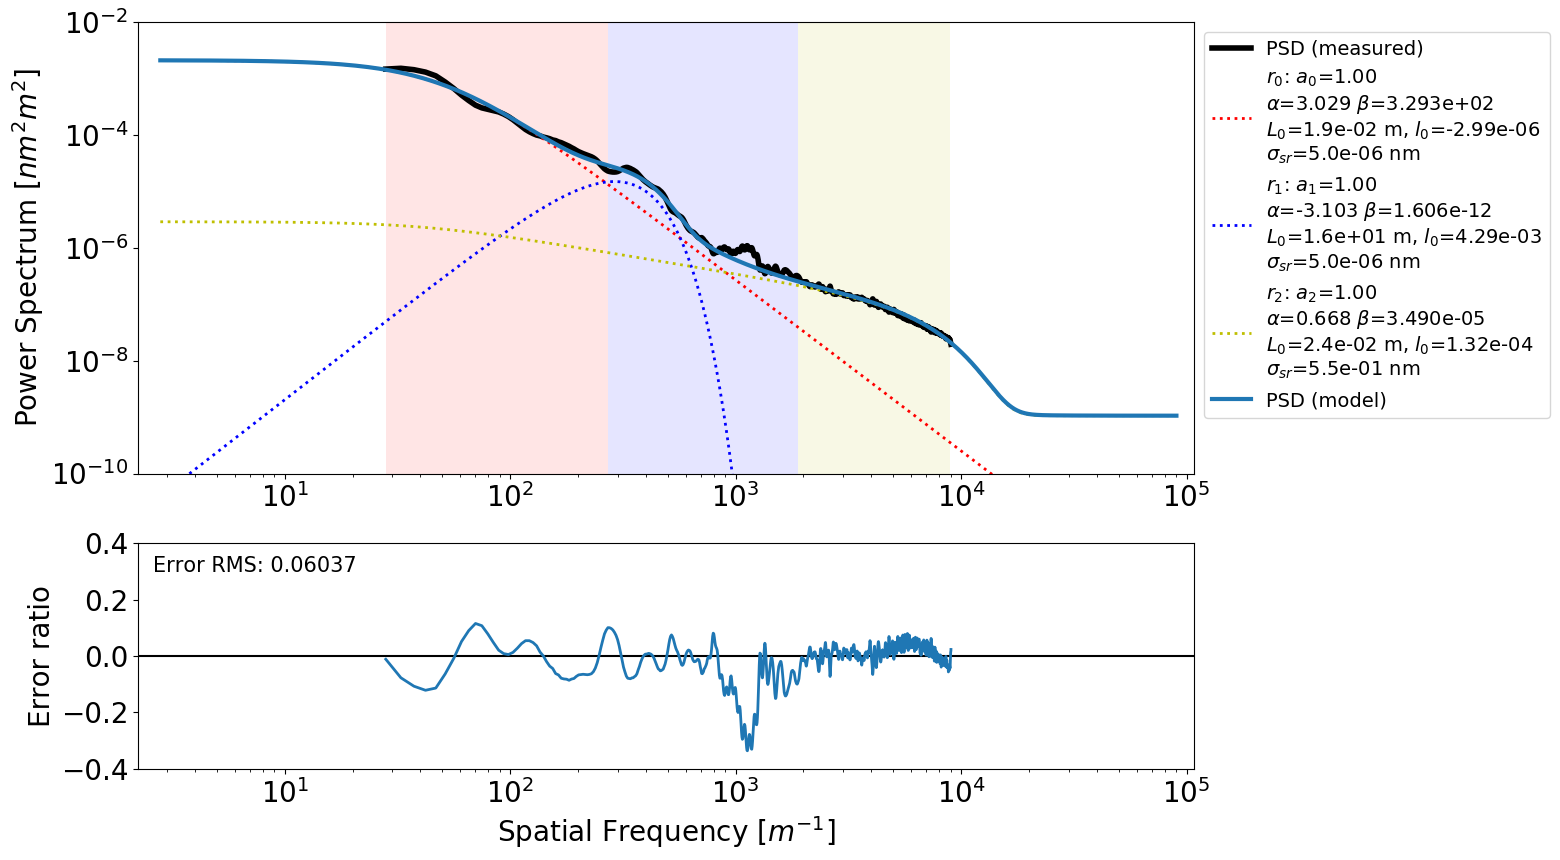

In [8]:
psd_plot(mdl_set, ms_refit, avg_psd, opt_parms, psd_lim=[1e-2, 1e-10])

In [6]:
# set the spatial frequency regions based on the index values
k_start = []
k_end = []
for k in range(0, len(ist)):
    k_start.append(avg_psd.k_radial[ist[k]].value)
    k_end.append(avg_psd.k_radial[iend[k]].value)
k_start*=avg_psd.k_radial[0].unit
k_end*=avg_psd.k_radial[0].unit

# set the names
parm_name = 'psd_{0}'.format(opt_parms['label'])
weight_name = parm_name + '_weight'
rms_name = parm_name + '_rms'

# set the PSD dictionary values
psd_dict = {parm_name: ms_refit.psd_parm,
            weight_name: psd_weight,
            rms_name: avg_psd.rms_tot,
            'k_start': k_start,
            'k_end': k_end,
            'rms_mod': ms_refit.psd_rms_sum,
            'rms_err': ms_refit.error_rms,
            'k_range': ms_refit.k_radial_data,
            'err_data': ms_refit.error,
            'mdl_data': ms_refit.psd_radial_sum_data,
            'psd_data': ms_refit.psd_radial_data}

# save the dictionary as a .FITS table file
fits_filename = 'model_parameters/psd_parms_{0}.fits'.format(opt_parms['label'])
#psd.psd_model_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'], 
#                     fits_filename=fits_filename,
#                     surf_unit=u.nm, lat_unit=u.m)

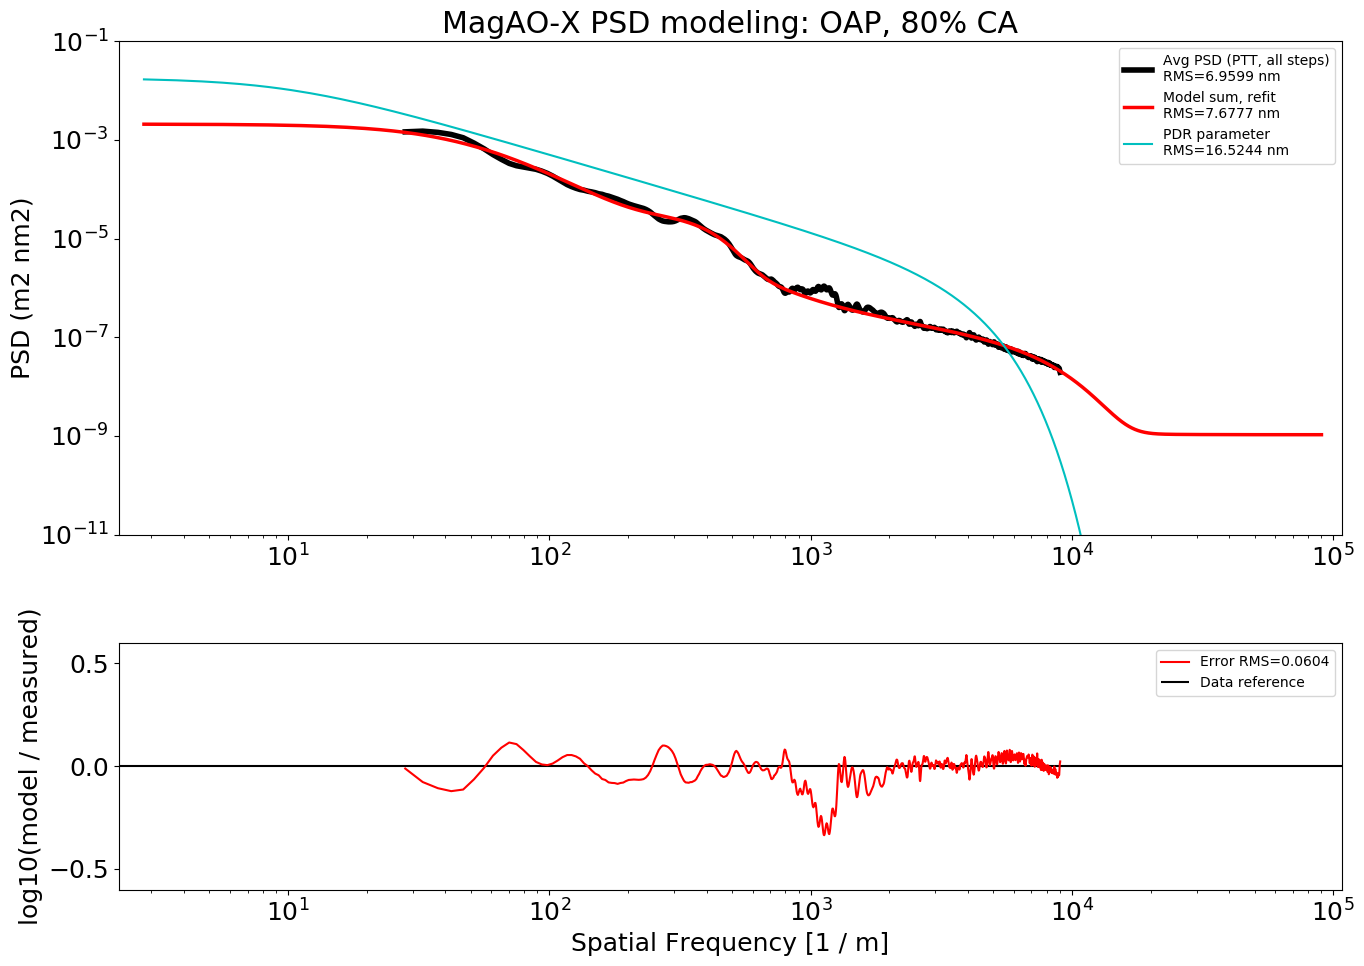

In [8]:
# pdr parameters
ap = 1.55
bp = 0.637 * (u.nm**2)/(u.m**(ap-2))
parm_pdr = [ap, bp, 0.1*u.m, 0.0003, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)
pdr_weight = [1.0]

pdr_rms = psd.calc_model_rms(psd_parm=[parm_pdr], psd_weight=pdr_weight, 
                             side=ms_refit.side, delta_k=ms_refit.delta_k,
                             k_tgt_lim=[ms_refit.k_min, ms_refit.k_max])

k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[14,10],dpi=100, facecolor='white')
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR parameter\nRMS={0:.4f}'.format(pdr_rms))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(top=1e-1, bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling: {0}, {1}% CA'.format('OAP',opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / measured)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()

### Test with poppy psd wfe code
Note: this was tested with obsolete poppy code, don't run

Text(0.5, 1.0, 'PSD oap, RMS=15.6308 nm, PV=135.39 nm')

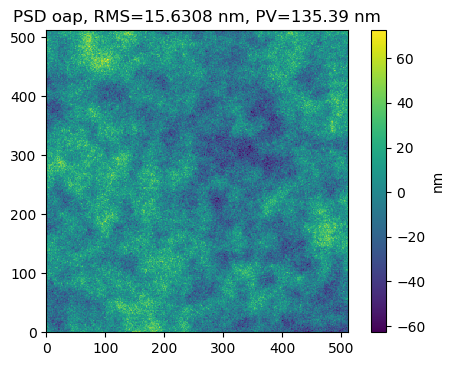

In [27]:
psd_weight_oap = [1.0, 1.0, 1.0]

screen_size = 2048
seed = 5 #123456
npix = 512
diam = 0.02587875072 * u.m
surf_unit = u.nm

def rms(opd):
    return np.sqrt(np.mean(np.square(opd)))

def pv(opd):
    return np.amax(opd) - np.amin(opd)

import poppy
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=ms_refit.psd_parm, psd_weight=psd_weight,
                                seed=seed, apply_reflection=True, #screen_size=screen_size,
                                wfe=avg_psd.rms_tot)
psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surf_unit)
psd_rms = rms(psd_opd)
psd_pv = pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.value, origin='lower')
plt.colorbar().set_label(psd_opd.unit)
plt.title('PSD oap, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))